In [71]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.core import Dropout, Flatten, Activation, Dense
from tensorflow.python.keras.layers.convolutional import Convolution2D
from tensorflow.python.keras.layers.pooling import MaxPooling2D

In [67]:
path = './SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing'
train_df = pd.read_csv("%s/train.txt" % (path), sep=" ", names=["image", "score"])
test_df = pd.read_csv("%s/test.txt" % (path), sep=" ", names=["image", "score"])

train_df['purpose'] = 'train'
test_df['purpose'] = 'test'

In [68]:
np.random.seed(15) #important for reproducability
val_set_size = int((40*train_df.shape[0])/100)
val_idx = np.random.choice(train_df.shape[0], size=val_set_size)
train_df.loc[val_idx, 'purpose'] = 'validation'
 
df = pd.concat([train_df, test_df])
del train_df, test_df
 
df.sample(5)

,image,score,purpose
712,CM316.jpg,2.716667,train
3299,AF292.jpg,2.783333,train
1989,AM1167.jpg,2.733333,train
607,AM972.jpg,2.583333,test
2246,CM56.jpg,2.316667,train


In [69]:
pd.DataFrame(df.purpose.value_counts()).rename(columns = {"purpose": "instances"})

,instances
train,2205
test,2200
validation,1095


In [77]:
def retrievePixels(img_name):
    path = "./SCUT-FBP5500_v2/Images/%s" % (img_name)
    img = image.load_img(path, grayscale=False, target_size=(224, 224))
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['image'].apply(retrievePixels)

features = []
pixels = df['pixels'].values
for i in range(0, pixels.shape[0]):
    features.append(pixels[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)
features = features / 255 #normalize inputs within [0, 1]

In [6]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

from keras.models import model_from_json
#load pre-trained weights of vgg-face model.
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('./vgg_face_weights.h5')

In [7]:
num_of_classes = 1 #this is a regression problem
 
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Flatten()(model.layers[-4].output)
base_model_output = Dense(num_of_classes)(base_model_output)
 
beauty_model = Model(inputs=model.input, outputs=base_model_output)

beauty_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
 
checkpointer = ModelCheckpoint(
    filepath='beauty_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [78]:
train_idx = df[(df['purpose'] == 'train')].index
val_idx = df[(df['purpose'] == 'validation')].index
test_idx = df[(df['purpose'] == 'test')].index

In [10]:
score = beauty_model.fit(
    features[train_idx], df.iloc[train_idx].score
    , epochs=200
    , validation_data=(features[val_idx], df.iloc[val_idx].score)
    , callbacks=[checkpointer, earlyStop]
)

Epoch 1/200
69/69 [==============================] - 174s 3s/step - loss: 1.1118 - val_loss: 0.2824

Epoch 00001: val_loss improved from inf to 0.28235, saving model to beauty_model.hdf5
Epoch 2/200
69/69 [==============================] - 148s 2s/step - loss: 0.3036 - val_loss: 0.1725

Epoch 00002: val_loss improved from 0.28235 to 0.17250, saving model to beauty_model.hdf5
Epoch 3/200
69/69 [==============================] - 148s 2s/step - loss: 0.3290 - val_loss: 0.2209

Epoch 00003: val_loss did not improve from 0.17250
Epoch 4/200
69/69 [==============================] - 149s 2s/step - loss: 0.2230 - val_loss: 0.1767

Epoch 00004: val_loss did not improve from 0.17250
Epoch 5/200
69/69 [==============================] - 149s 2s/step - loss: 0.2137 - val_loss: 0.1967

Epoch 00005: val_loss did not improve from 0.17250
Epoch 6/200
69/69 [==============================] - 149s 2s/step - loss: 0.2180 - val_loss: 0.2045

Epoch 00006: val_loss did not improve from 0.17250
Epoch 7/200
69

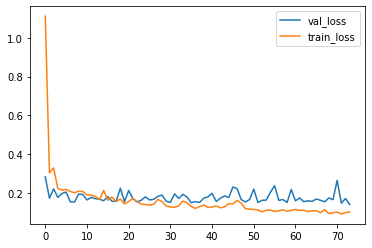

In [11]:
best_iteration = np.argmin(score.history['val_loss'])+1
 
val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]
 
plt.plot(val_scores, label='val_loss')
plt.plot(train_scores, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [79]:
actuals = df.iloc[test_idx].score.values
predictions = beauty_model.predict(features[test_idx])
 
perf = pd.DataFrame(actuals, columns = ["actuals"])
perf["predictions"] = predictions
print("PC: ",perf[['actuals', 'predictions']].corr(method ='pearson').values[0,1])
print("MAE: ", mean_absolute_error(actuals, predictions))
print("RMSE: ", sqrt(mean_squared_error(actuals, predictions)))

PC:  0.9357644304438376
MAE:  0.23794536716715378
RMSE:  0.32015566657958905


In [81]:
perf.to_csv('./SCUT_prediction.csv', index=False)

In [13]:
beauty_model.save('./BM_200.h5')

In [19]:
import xml.etree.ElementTree as Xet

cols = ['index', 'filename', 'score', 'num_ratings']
rows = []

# Parsing the XML file
xmlparse = Xet.parse('./eccv2010_beauty_data/hotornot_face_all.xml')
root = xmlparse.getroot()
for i in root:
    index = i.attrib.get('id')
    filename = i.attrib.get('filename')
    score = i.attrib.get('score')
    num_ratings = i.attrib.get('num_ratings')

    rows.append({
        'id' : index,
        'filename' : filename,
        'score' : score,
        'num_ratings' : num_ratings
    })
pre_df = pd.DataFrame(rows, columns=cols)
pre_df.to_csv('./Eccv2010.csv')

In [34]:
# Image resize and save
from PIL import Image
pre_df = pd.read_csv('./Eccv2010.csv',sep=",")

for i in pre_df.filename:
    path = "./eccv2010_beauty_data/%s" % (i)
    image = Image.open(path)
    new_img = image.resize((224, 224))
    new_img.save('./Eccv2010_data/%s' % (i))

In [49]:
def retrievePixels2(img_name):
    path = './Eccv2010_data/%s' % (img_name)
    img = image.load_img(path, grayscale=False, target_size=(224, 224))
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

pre_df['pixels'] = pre_df['filename'].apply(retrievePixels2)

features = []
pixels = pre_df['pixels'].values
for i in range(0, pixels.shape[0]):
    features.append(pixels[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)
features = features / 255 #normalize inputs within [0, 1]

In [62]:
predictions = beauty_model.predict(features)

In [63]:
pre_actuals = (pre_df.score.values + 4) / 8 * 5

perf = pd.DataFrame(pre_actuals, columns = ["actuals"])
perf["predictions"] = predictions
print("PC: ",perf[['actuals', 'predictions']].corr(method ='pearson').values[0,1])
print("MAE: ", mean_absolute_error(pre_actuals, predictions))
print("RMSE: ", sqrt(mean_squared_error(pre_actuals, predictions)))

PC:  0.3394916855450278
MAE:  0.5913646937554754
RMSE:  0.7480878888658133


In [64]:
perf.to_csv('./prediction.csv', index= False)